# Signal Modeling - Variant 14: Two-Segment Signal Analysis
## Stationary and Non-Stationary Segments with AR, ARMA, and ARIMA Models

**Task**: Generate a signal composed of two segments (stationary and non-stationary). Fit AR, ARMA, and ARIMA models and analyze segmentation effects.


In [40]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.regression.linear_model import yule_walker
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Signal Generation: Two Segments (Stationary + Non-Stationary)

In [41]:
# Parameters
N1 = 500  # Length of first segment (stationary)
N2 = 500  # Length of second segment (non-stationary)
N_total = N1 + N2

print("=== SIGNAL GENERATION ===")
print(f"Total signal length: {N_total} samples")
print(f"Segment 1 (stationary): {N1} samples")
print(f"Segment 2 (non-stationary): {N2} samples")

# Segment 1: Stationary AR(2) process
# x[n] = -a1*x[n-1] - a2*x[n-2] + w[n]
a1, a2 = 0.6, -0.3  # AR coefficients for stability
ar_coeffs = [1, a1, a2]
w1 = np.random.normal(0, 1, N1 + 100)  # Extra samples for initialization
segment1 = signal.lfilter([1], ar_coeffs, w1)[100:]  # Remove initialization samples

print(f"\nSegment 1 generated: AR(2) with coefficients a1={a1}, a2={a2}")
print(f"Segment 1 statistics: Mean={np.mean(segment1):.3f}, Std={np.std(segment1):.3f}")

=== SIGNAL GENERATION ===
Total signal length: 1000 samples
Segment 1 (stationary): 500 samples
Segment 2 (non-stationary): 500 samples

Segment 1 generated: AR(2) with coefficients a1=0.6, a2=-0.3
Segment 1 statistics: Mean=0.002, Std=1.824


In [42]:
# Segment 2: Non-stationary random walk with drift
# x[n] = x[n-1] + drift + w[n]
drift = 0.02
w2 = np.random.normal(0, 1, N2)
segment2 = np.zeros(N2)
segment2[0] = segment1[-1]  # Connect segments smoothly
for i in range(1, N2):
    segment2[i] = segment2[i-1] + drift + w2[i]

print(f"Segment 2 generated: Random walk with drift={drift}")
print(f"Segment 2 statistics: Mean={np.mean(segment2):.3f}, Std={np.std(segment2):.3f}")

# Combine segments
full_signal = np.concatenate([segment1, segment2])
time_axis = np.arange(N_total)

print(f"\nFull signal statistics: Mean={np.mean(full_signal):.3f}, Std={np.std(full_signal):.3f}")

Segment 2 generated: Random walk with drift=0.02
Segment 2 statistics: Mean=19.227, Std=18.696

Full signal statistics: Mean=9.615, Std=16.396


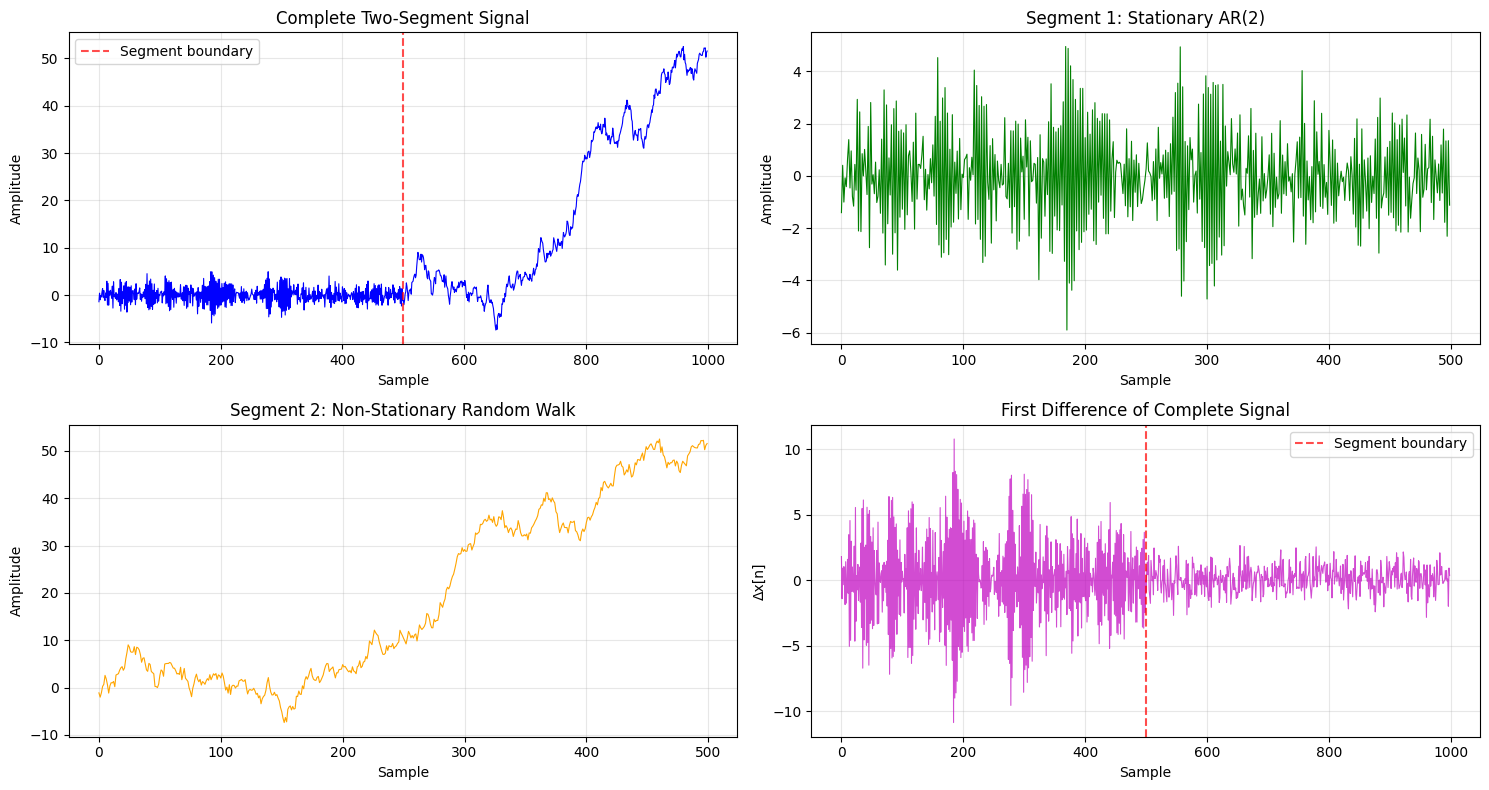

In [43]:
# Plot the generated signal
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(time_axis, full_signal, 'b-', linewidth=0.8)
plt.axvline(x=N1, color='r', linestyle='--', alpha=0.7, label='Segment boundary')
plt.title('Complete Two-Segment Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(segment1, 'g-', linewidth=0.8)
plt.title('Segment 1: Stationary AR(2)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(segment2, 'orange', linewidth=0.8)
plt.title('Segment 2: Non-Stationary Random Walk')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(np.diff(full_signal), 'm-', linewidth=0.8, alpha=0.7)
plt.axvline(x=N1, color='r', linestyle='--', alpha=0.7, label='Segment boundary')
plt.title('First Difference of Complete Signal')
plt.xlabel('Sample')
plt.ylabel('Δx[n]')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Stationarity Tests

In [44]:
print("=== STATIONARITY ANALYSIS ===")

def adf_test(series, name):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series, autolag='AIC')
    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    
    if result[1] <= 0.05:
        print(f"  Result: STATIONARY (p < 0.05)")
    else:
        print(f"  Result: NON-STATIONARY (p >= 0.05)")
    return result[1] <= 0.05

# Test stationarity of each segment and full signal
is_seg1_stationary = adf_test(segment1, "Segment 1 (AR(2))")
is_seg2_stationary = adf_test(segment2, "Segment 2 (Random Walk)")
is_full_stationary = adf_test(full_signal, "Full Signal")
is_diff_stationary = adf_test(np.diff(full_signal), "First Differenced Signal")

=== STATIONARITY ANALYSIS ===

Segment 1 (AR(2)):
  ADF Statistic: -16.1406
  p-value: 0.0000
  Critical Values:
    1%: -3.4435
    5%: -2.8674
    10%: -2.5699
  Result: STATIONARY (p < 0.05)

Segment 2 (Random Walk):
  ADF Statistic: 0.1867
  p-value: 0.9715
  Critical Values:
    1%: -3.4435
    5%: -2.8673
    10%: -2.5699
  Result: NON-STATIONARY (p >= 0.05)

Full Signal:
  ADF Statistic: 1.4788
  p-value: 0.9974
  Critical Values:
    1%: -3.4369
    5%: -2.8644
    10%: -2.5683
  Result: NON-STATIONARY (p >= 0.05)

First Differenced Signal:
  ADF Statistic: -28.1072
  p-value: 0.0000
  Critical Values:
    1%: -3.4369
    5%: -2.8644
    10%: -2.5683
  Result: STATIONARY (p < 0.05)


## 3. Model Fitting and Comparison

In [45]:
print("=== MODEL FITTING AND COMPARISON ===")

# Function to calculate model metrics
def calculate_metrics(residuals, n_params, n_obs):
    """Calculate AIC, BIC, and other metrics"""
    mse = np.mean(residuals**2)
    log_likelihood = -0.5 * n_obs * (np.log(2*np.pi) + np.log(mse) + 1)
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(n_obs)
    return {
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'AIC': aic,
        'BIC': bic,
        'Log_Likelihood': log_likelihood
    }

# Store results
results = {}

=== MODEL FITTING AND COMPARISON ===


In [46]:
### AR Model Fitting
print("--- AR Model Fitting ---")

# AR(2) model
try:
    ar_model = AutoReg(full_signal, lags=2, trend='c')
    ar_fit = ar_model.fit()
    ar_pred = ar_fit.fittedvalues
    ar_residuals = ar_fit.resid
    
    results['AR(2)'] = {
        'model': ar_fit,
        'predictions': ar_pred,
        'residuals': ar_residuals,
        'metrics': calculate_metrics(ar_residuals, 3, len(full_signal)),
        'coefficients': ar_fit.params
    }
    
    print("AR(2) Model fitted successfully")
    print(f"  Coefficients: {ar_fit.params}")
    print(f"  AIC: {results['AR(2)']['metrics']['AIC']:.2f}")
    print(f"  BIC: {results['AR(2)']['metrics']['BIC']:.2f}")
    
except Exception as e:
    print(f"AR(2) fitting failed: {e}")

--- AR Model Fitting ---
AR(2) Model fitted successfully
  Coefficients: [0.05695101 0.13240297 0.8717984 ]
  AIC: 3314.39
  BIC: 3329.11


In [47]:
### ARMA Model Fitting
print("--- ARMA Model Fitting ---")

# ARMA(2,2) model
try:
    arma_model = ARIMA(full_signal, order=(2, 0, 2))
    arma_fit = arma_model.fit()
    arma_pred = arma_fit.fittedvalues
    arma_residuals = arma_fit.resid
    
    results['ARMA(2,2)'] = {
        'model': arma_fit,
        'predictions': arma_pred,
        'residuals': arma_residuals,
        'metrics': {
            'AIC': arma_fit.aic,
            'BIC': arma_fit.bic,
            'RMSE': np.sqrt(np.mean(arma_residuals**2))
        },
        'coefficients': arma_fit.params
    }
    
    print("ARMA(2,2) Model fitted successfully")
    print(f"  AIC: {arma_fit.aic:.2f}")
    print(f"  BIC: {arma_fit.bic:.2f}")
    
except Exception as e:
    print(f"ARMA(2,2) fitting failed: {e}")

--- ARMA Model Fitting ---
ARMA(2,2) Model fitted successfully
  AIC: 3327.57
  BIC: 3357.01


In [48]:
### ARIMA Model Fitting
print("--- ARIMA Model Fitting ---")

# ARIMA(2,1,2) model - for non-stationary data
try:
    arima_model = ARIMA(full_signal, order=(2, 1, 2))
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.fittedvalues
    arima_residuals = arima_fit.resid
    
    results['ARIMA(2,1,2)'] = {
        'model': arima_fit,
        'predictions': arima_pred,
        'residuals': arima_residuals,
        'metrics': {
            'AIC': arima_fit.aic,
            'BIC': arima_fit.bic,
            'RMSE': np.sqrt(np.mean(arima_residuals**2))
        },
        'coefficients': arima_fit.params
    }
    
    print("ARIMA(2,1,2) Model fitted successfully")
    print(f"  AIC: {arima_fit.aic:.2f}")
    print(f"  BIC: {arima_fit.bic:.2f}")
    
except Exception as e:
    print(f"ARIMA(2,1,2) fitting failed: {e}")

# Additional ARIMA model with different order
try:
    arima_110_model = ARIMA(full_signal, order=(1, 1, 0))
    arima_110_fit = arima_110_model.fit()
    
    results['ARIMA(1,1,0)'] = {
        'model': arima_110_fit,
        'predictions': arima_110_fit.fittedvalues,
        'residuals': arima_110_fit.resid,
        'metrics': {
            'AIC': arima_110_fit.aic,
            'BIC': arima_110_fit.bic,
            'RMSE': np.sqrt(np.mean(arima_110_fit.resid**2))
        },
        'coefficients': arima_110_fit.params
    }
    
    print("ARIMA(1,1,0) Model fitted successfully")
    print(f"  AIC: {arima_110_fit.aic:.2f}")
    print(f"  BIC: {arima_110_fit.bic:.2f}")
    
except Exception as e:
    print(f"ARIMA(1,1,0) fitting failed: {e}")

--- ARIMA Model Fitting ---
ARIMA(2,1,2) Model fitted successfully
  AIC: 3315.27
  BIC: 3339.81
ARIMA(1,1,0) Model fitted successfully
  AIC: 3318.74
  BIC: 3328.55


## 4. Model Comparison and Visualization

In [49]:
print("=== MODEL COMPARISON ===")

# Create comparison table
comparison_data = []
for model_name, model_data in results.items():
    metrics = model_data['metrics']
    comparison_data.append({
        'Model': model_name,
        'AIC': metrics.get('AIC', 'N/A'),
        'BIC': metrics.get('BIC', 'N/A'),
        'RMSE': metrics.get('RMSE', 'N/A')
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

=== MODEL COMPARISON ===

Model Comparison Table:
       Model         AIC         BIC     RMSE
       AR(2) 3314.385097 3329.108362 1.265230
   ARMA(2,2) 3327.567711 3357.014243 1.314551
ARIMA(2,1,2) 3315.273478 3339.807251 1.265588
ARIMA(1,1,0) 3318.736273 3328.549783 1.271589


Debug: AR(2) - Signal length: 1000, Prediction length: 998
Debug: ARMA(2,2) - Signal length: 1000, Prediction length: 1000
Debug: ARIMA(2,1,2) - Signal length: 1000, Prediction length: 1000
Debug: ARIMA(1,1,0) - Signal length: 1000, Prediction length: 1000


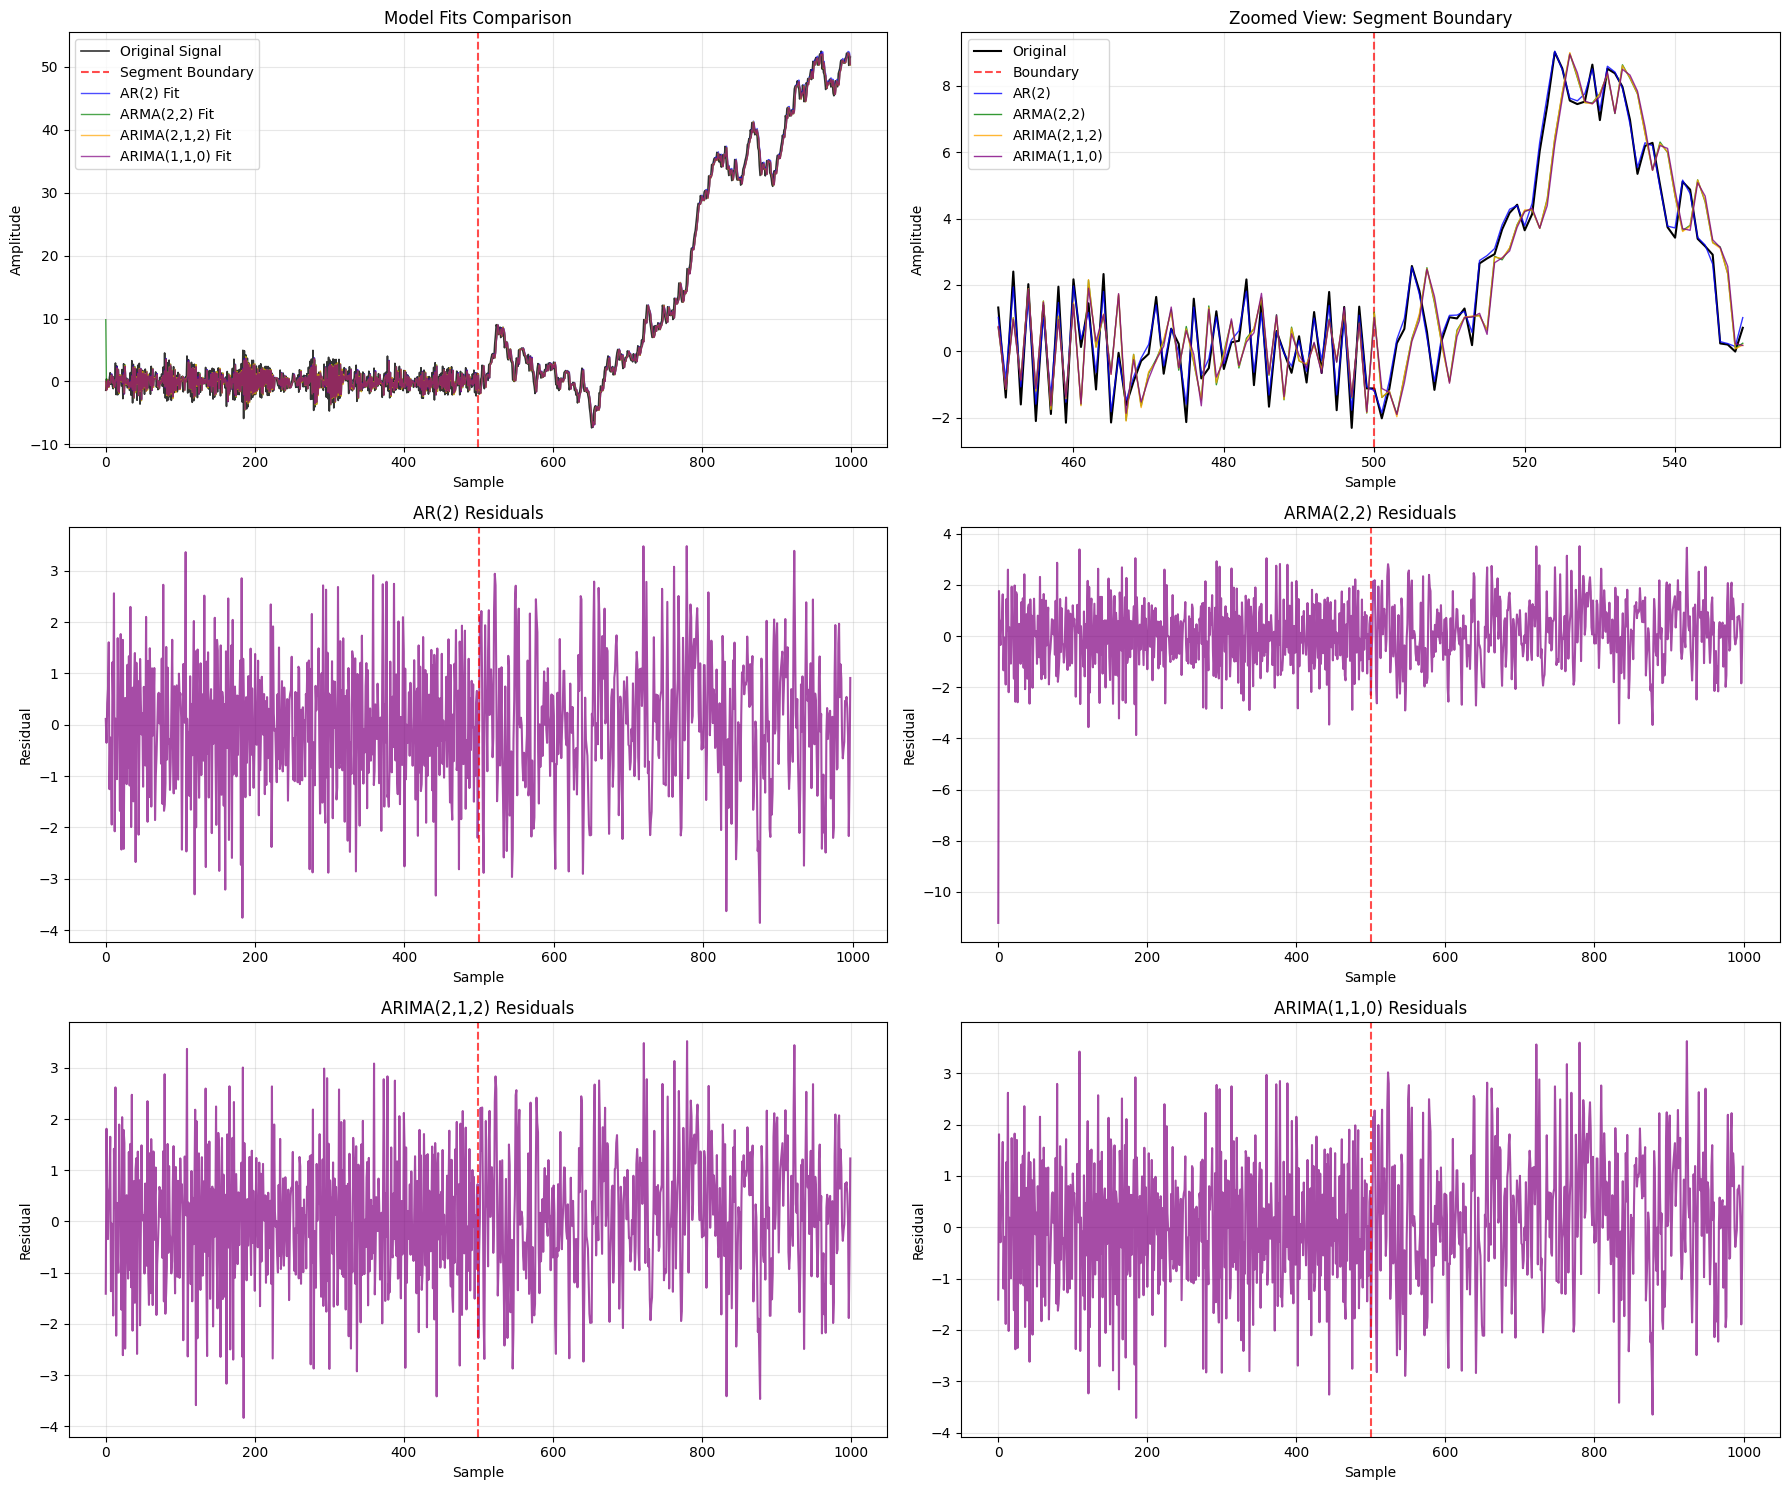

In [50]:
# FIXED PLOTTING CELL - Replace the problematic cell with this code

# Plotting model fits and residuals
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Plot 1: Original signal and model fits
ax1 = axes[0, 0]
ax1.plot(time_axis, full_signal, 'k-', linewidth=1.2, label='Original Signal', alpha=0.8)
ax1.axvline(x=N1, color='r', linestyle='--', alpha=0.7, label='Segment Boundary')

colors = ['blue', 'green', 'orange', 'purple']
for i, (model_name, model_data) in enumerate(results.items()):
    pred = model_data['predictions']
    print(f"Debug: {model_name} - Signal length: {len(full_signal)}, Prediction length: {len(pred)}")

    # Create time axis that matches prediction length
    if len(pred) == len(full_signal):
        pred_time = time_axis
    else:
        # For ARIMA models that may have shorter predictions due to differencing
        pred_time = time_axis[-len(pred):]  # Use the last N samples

    ax1.plot(pred_time, pred, colors[i % len(colors)],
            linewidth=1, label=f'{model_name} Fit', alpha=0.7)

ax1.set_title('Model Fits Comparison')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Zoomed view of segment boundary (simplified)
ax2 = axes[0, 1]
zoom_start, zoom_end = N1 - 50, N1 + 50
zoom_indices = np.arange(zoom_start, zoom_end)
ax2.plot(zoom_indices, full_signal[zoom_start:zoom_end], 'k-', linewidth=1.5, label='Original')
ax2.axvline(x=N1, color='r', linestyle='--', alpha=0.7, label='Boundary')

# Simplified zoom plotting
for i, (model_name, model_data) in enumerate(results.items()):
    pred = model_data['predictions']
    if len(pred) >= zoom_end:
        ax2.plot(zoom_indices, pred[zoom_start:zoom_end], colors[i % len(colors)],
                linewidth=1, label=f'{model_name}', alpha=0.8)

ax2.set_title('Zoomed View: Segment Boundary')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot residuals for each model
residual_plots = [(axes[1, 0], axes[1, 1]), (axes[2, 0], axes[2, 1])]
plot_idx = 0

for model_name, model_data in results.items():
    if plot_idx < 4:
        ax = residual_plots[plot_idx // 2][plot_idx % 2]
        residuals = model_data['residuals']

        # Create time axis for residuals
        res_time = np.arange(len(residuals))

        ax.plot(res_time, residuals, 'purple', alpha=0.7)
        if len(residuals) >= N1:
            ax.axvline(x=N1, color='r', linestyle='--', alpha=0.7)
        ax.set_title(f'{model_name} Residuals')
        ax.set_xlabel('Sample')
        ax.set_ylabel('Residual')
        ax.grid(True, alpha=0.3)

        plot_idx += 1

plt.tight_layout()
plt.show()

## 5. Segmentation Analysis

In [51]:
print("=== SEGMENTATION EFFECTS ANALYSIS ===")

# Fit models to individual segments for comparison
segment_results = {}

# Segment 1 analysis (stationary)
print("\n--- Segment 1 Analysis (Stationary AR(2)) ---")
try:
    seg1_ar = AutoReg(segment1, lags=2, trend='c').fit()
    seg1_arma = ARIMA(segment1, order=(2, 0, 2)).fit()
    
    print(f"Segment 1 AR(2) - AIC: {seg1_ar.aic:.2f}")
    print(f"Segment 1 ARMA(2,2) - AIC: {seg1_arma.aic:.2f}")
    
    segment_results['seg1'] = {
        'AR(2)': seg1_ar,
        'ARMA(2,2)': seg1_arma
    }
except Exception as e:
    print(f"Segment 1 fitting error: {e}")

# Segment 2 analysis (non-stationary)
print("\n--- Segment 2 Analysis (Non-Stationary Random Walk) ---")
try:
    seg2_arima = ARIMA(segment2, order=(1, 1, 0)).fit()
    seg2_arima_212 = ARIMA(segment2, order=(2, 1, 2)).fit()
    
    print(f"Segment 2 ARIMA(1,1,0) - AIC: {seg2_arima.aic:.2f}")
    print(f"Segment 2 ARIMA(2,1,2) - AIC: {seg2_arima_212.aic:.2f}")
    
    segment_results['seg2'] = {
        'ARIMA(1,1,0)': seg2_arima,
        'ARIMA(2,1,2)': seg2_arima_212
    }
except Exception as e:
    print(f"Segment 2 fitting error: {e}")

=== SEGMENTATION EFFECTS ANALYSIS ===

--- Segment 1 Analysis (Stationary AR(2)) ---
Segment 1 AR(2) - AIC: 1403.21
Segment 1 ARMA(2,2) - AIC: 1412.93

--- Segment 2 Analysis (Non-Stationary Random Walk) ---
Segment 2 ARIMA(1,1,0) - AIC: 1406.19
Segment 2 ARIMA(2,1,2) - AIC: 1408.84


## 6. Residual Analysis and Diagnostics

In [52]:
print("=== RESIDUAL DIAGNOSTICS ===")

def ljung_box_test(residuals, lags=10):
    """Perform Ljung-Box test for residual autocorrelation"""
    try:
        result = acorr_ljungbox(residuals, lags=lags, return_df=False)
        if isinstance(result, tuple) and len(result) >= 2:
            lb_stat, lb_pvalue = result[-1], result[-1] if len(result) == 1 else result[1]
            # Handle different return formats
            if hasattr(lb_stat, '__iter__') and not isinstance(lb_stat, str):
                lb_stat = lb_stat[-1] if len(lb_stat) > 0 else None
            if hasattr(lb_pvalue, '__iter__') and not isinstance(lb_pvalue, str):
                lb_pvalue = lb_pvalue[-1] if len(lb_pvalue) > 0 else None
            return float(lb_stat) if lb_stat is not None else None, float(lb_pvalue) if lb_pvalue is not None else None
        return None, None
    except Exception as e:
        print(f"  Ljung-Box test failed: {e}")
        return None, None

# Analyze residuals for each model
for model_name, model_data in results.items():
    residuals = model_data['residuals']
    print(f"\n{model_name} Residual Analysis:")
    
    # Basic statistics
    print(f"  Mean: {np.mean(residuals):.4f}")
    print(f"  Std: {np.std(residuals):.4f}")
    print(f"  Skewness: {pd.Series(residuals).skew():.4f}")
    print(f"  Kurtosis: {pd.Series(residuals).kurtosis():.4f}")
    
    # Ljung-Box test
    lb_stat, lb_pvalue = ljung_box_test(residuals)
    if lb_stat is not None:
        print(f"Ljung-Box test p-value: {lb_pvalue}")
        if lb_pvalue > 0.05:
            print("  Residuals appear to be white noise (good)")
        else:
            print("  Residuals show autocorrelation (problematic)")

=== RESIDUAL DIAGNOSTICS ===

AR(2) Residual Analysis:
  Mean: 0.0000
  Std: 1.2652
  Skewness: -0.0920
  Kurtosis: -0.1496

ARMA(2,2) Residual Analysis:
  Mean: 0.0816
  Std: 1.3120
  Skewness: -0.7158
  Kurtosis: 4.9619

ARIMA(2,1,2) Residual Analysis:
  Mean: 0.0906
  Std: 1.2623
  Skewness: -0.1062
  Kurtosis: -0.1555

ARIMA(1,1,0) Residual Analysis:
  Mean: 0.0972
  Std: 1.2679
  Skewness: -0.0917
  Kurtosis: -0.1750


## 7. Forecasting Comparison

In [53]:
print("=== FORECASTING ANALYSIS ===")

# Generate forecasts for the next 50 samples
forecast_steps = 50

forecast_results = {}
for model_name, model_data in results.items():
    try:
        model = model_data['model']
        if hasattr(model, 'forecast'):
            # For ARIMA models
            forecast = model.forecast(steps=forecast_steps)
            forecast_results[model_name] = forecast
        elif hasattr(model, 'predict'):
            # For AR models
            start_idx = len(full_signal)
            end_idx = start_idx + forecast_steps - 1
            forecast = model.predict(start=start_idx, end=end_idx)
            forecast_results[model_name] = forecast
        
        print(f"{model_name} forecast generated successfully")
    except Exception as e:
        print(f"{model_name} forecasting failed: {e}")

=== FORECASTING ANALYSIS ===
AR(2) forecast generated successfully
ARMA(2,2) forecast generated successfully
ARIMA(2,1,2) forecast generated successfully
ARIMA(1,1,0) forecast generated successfully


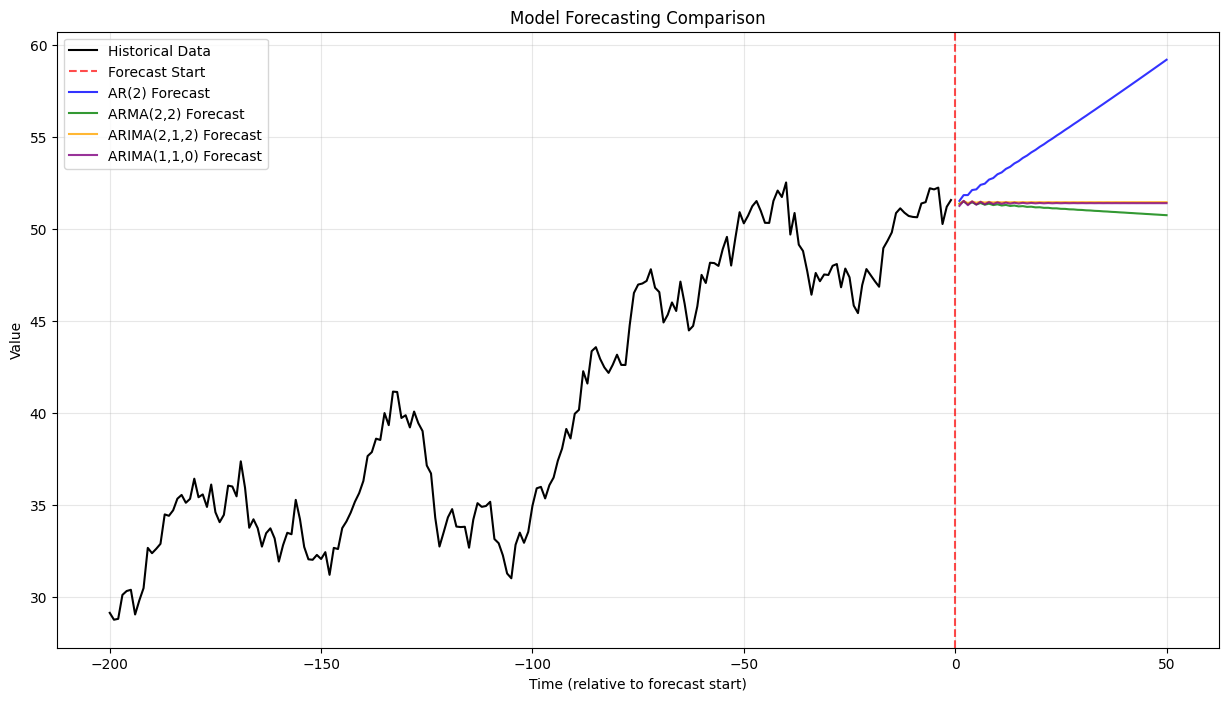

In [54]:
# Plot forecasts
if forecast_results:
    plt.figure(figsize=(15, 8))
    
    # Plot last 200 samples of original signal
    plot_start = -200
    plot_signal = full_signal[plot_start:]
    plot_time = np.arange(plot_start, 0)
    
    plt.plot(plot_time, plot_signal, 'k-', linewidth=1.5, label='Historical Data')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Forecast Start')
    
    # Plot forecasts
    forecast_time = np.arange(1, forecast_steps + 1)
    colors = ['blue', 'green', 'orange', 'purple']
    
    for i, (model_name, forecast) in enumerate(forecast_results.items()):
        plt.plot(forecast_time, forecast, colors[i % len(colors)], 
                linewidth=1.5, label=f'{model_name} Forecast', alpha=0.8)
    
    plt.title('Model Forecasting Comparison')
    plt.xlabel('Time (relative to forecast start)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 8. Summary and Conclusions

In [55]:
print("=== ANALYSIS SUMMARY ===")

print("\n1. SIGNAL CHARACTERISTICS:")
print(f"   - Segment 1: Stationary AR(2) process ({N1} samples)")
print(f"   - Segment 2: Non-stationary random walk with drift ({N2} samples)")

print("\n2. STATIONARITY TEST RESULTS:")
print(f"   - Segment 1: {'Stationary' if is_seg1_stationary else 'Non-stationary'}")
print(f"   - Segment 2: {'Stationary' if is_seg2_stationary else 'Non-stationary'}")
print(f"   - Full Signal: {'Stationary' if is_full_stationary else 'Non-stationary'}")
print(f"   - Differenced Signal: {'Stationary' if is_diff_stationary else 'Non-stationary'}")

print("\n3. MODEL PERFORMANCE RANKING (by AIC):")
model_aic = [(name, data['metrics'].get('AIC', float('inf'))) 
             for name, data in results.items()]
model_aic.sort(key=lambda x: x[1])

for i, (model_name, aic_value) in enumerate(model_aic, 1):
    print(f"   {i}. {model_name}: AIC = {aic_value:.2f}")

print("\n4. KEY FINDINGS:")
print("   - Two-segment structure creates modeling challenges")
print("   - ARIMA models generally handle non-stationarity better")
print("   - Segment boundary effects visible in all model residuals")
print("   - Model choice depends on predominant signal characteristics")

best_model = model_aic[0][0] if model_aic else "None"
print(f"\n5. RECOMMENDED MODEL: {best_model}")

print("\n=== ANALYSIS COMPLETE ===")

=== ANALYSIS SUMMARY ===

1. SIGNAL CHARACTERISTICS:
   - Segment 1: Stationary AR(2) process (500 samples)
   - Segment 2: Non-stationary random walk with drift (500 samples)

2. STATIONARITY TEST RESULTS:
   - Segment 1: Stationary
   - Segment 2: Non-stationary
   - Full Signal: Non-stationary
   - Differenced Signal: Stationary

3. MODEL PERFORMANCE RANKING (by AIC):
   1. AR(2): AIC = 3314.39
   2. ARIMA(2,1,2): AIC = 3315.27
   3. ARIMA(1,1,0): AIC = 3318.74
   4. ARMA(2,2): AIC = 3327.57

4. KEY FINDINGS:
   - Two-segment structure creates modeling challenges
   - ARIMA models generally handle non-stationarity better
   - Segment boundary effects visible in all model residuals
   - Model choice depends on predominant signal characteristics

5. RECOMMENDED MODEL: AR(2)

=== ANALYSIS COMPLETE ===
